# Building a movie recommender with Naive Bayes

## Preparing the Data
### (dateset source: http://files.grouplens.org/datasets/movielens/ml-1m.zip) 

In [6]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

In [7]:
# Using MovieLens 1M dataset, which contains circa 1 million ratings
data_path = "C:/Users/S/_devrepos/PyML_by_Example/data_for_PyML_by_Ex/ch2_datasets/ml-1m/ratings.dat"



In [8]:
# creating and printing the dataframe
df = pd.read_csv(data_path, header=None, sep='::', engine='python')

In [4]:
df.columns = ['user_id', 'movie_id', 'rating', 'timestamp'] 

In [5]:
print(df)

         user_id  movie_id  rating  timestamp
0              1      1193       5  978300760
1              1       661       3  978302109
2              1       914       3  978301968
3              1      3408       4  978300275
4              1      2355       5  978824291
...          ...       ...     ...        ...
1000204     6040      1091       1  956716541
1000205     6040      1094       5  956704887
1000206     6040       562       5  956704746
1000207     6040      1096       4  956715648
1000208     6040      1097       4  956715569

[1000209 rows x 4 columns]


In [6]:
# viewing the number of unique viewers in the dataset of a million rows.
n_users = df['user_id'].nunique() 
n_movies = df['movie_id'].nunique() 
print(f"Number of users: {n_users}")

Number of users: 6040


In [7]:
print(f"Number of Movies: {n_movies}")

Number of Movies: 3706


In [8]:
# creating a matrix (6040 (number of users) x 3706 (number of movies) 
# also analyzing the data distribution to check for any class imbalances

def load_user_rating_data(df, n_users, n_movies): 
    data = np.zeros([n_users, n_movies], dtype=np.intc)
    movie_id_mapping = {}
         
    for user_id, movie_id, rating in  zip(df['user_id'], df['movie_id'], df['rating']):               
                user_id = int(user_id) - 1 
                if movie_id not in movie_id_mapping:
                    movie_id_mapping[movie_id] = len(movie_id_mapping) 
                data[user_id, movie_id_mapping[movie_id]] = rating 
    return data, movie_id_mapping 
    
    data, movie_id_mapping = load_user_rating_data(df, n_users, n_movies)
    values, counts = np.unique(data, return_counts=True) 
    for value, count in zip(values, counts): 
            print(f'Number of rating  {value}: {count}')

     
    

In [9]:
print(df['movie_id'].value_counts())

movie_id
2858    3428
260     2991
1196    2990
1210    2883
480     2672
        ... 
3458       1
2226       1
1815       1
398        1
2909       1
Name: count, Length: 3706, dtype: int64


In [10]:
# Take the movie from the previous step with the most ratings (movie ID = 2858) as the target movie for ease of prediction validation.

target_movie_id = 2858 
data = np.zeros([n_users, n_movies], dtype=np.intc)
data, movie_id_mapping = load_user_rating_data(df, n_users, n_movies)
X_raw = np.delete(data, movie_id_mapping[target_movie_id], axis=1) 
Y_raw = data[:, movie_id_mapping[target_movie_id]] 
X = X_raw[Y_raw > 0 ] 
Y = Y_raw[Y_raw > 0 ] 
print('Shape of X:', X.shape)
print('Shape of Y:', Y.shape) 

Shape of X: (3428, 3705)
Shape of Y: (3428,)


In [11]:
# Movies with ratings greater than 3 will be considered as being liked (recommended).

recommend = 3
Y[Y <= recommend] = 0 
Y[Y > recommend] = 1 
n_pos = (Y == 1).sum() 
n_neg = ( Y == 0).sum() 
print(f'{n_pos} positive samples and {n_neg} negative samples.') 

2853 positive samples and 575 negative samples.


In [12]:
# Splitting the data randomly while preserving the % of samples for each class.
from sklearn.model_selection import train_test_split 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
test_size=0.2, random_state=42) 

In [13]:
# Check the training and testing sizes
print(len(Y_train), len(Y_test))

2742 686


# Training a Naive Bayes Model

In [14]:
# Train a Naive Bayes model on the set, with a Laplace Smoothing factor of 1.0
from sklearn.naive_bayes import MultinomialNB 
clf = MultinomialNB(alpha=1.0, fit_prior=True) 
clf.fit(X_train, Y_train) 

MultinomialNB()

In [15]:
# Use the trained model to make predictions on the testing set. The predicted probabilities are output:
prediction_prob = clf.predict_proba(X_test) 
print(prediction_prob[0:10])

[[7.50487439e-23 1.00000000e+00]
 [1.01806208e-01 8.98193792e-01]
 [3.57740570e-10 1.00000000e+00]
 [1.00000000e+00 2.94095407e-16]
 [1.00000000e+00 2.49760836e-25]
 [7.62630220e-01 2.37369780e-01]
 [3.47479627e-05 9.99965252e-01]
 [2.66075292e-11 1.00000000e+00]
 [5.88493563e-10 9.99999999e-01]
 [9.71326867e-09 9.99999990e-01]]


In [16]:
# The predicted class for  the test set.
prediction = clf.predict(X_test) 
print(prediction[:10]) 

[1 1 1 0 0 0 1 1 1 1]


In [17]:
# Evaluating the model's performance with classification accuracy (the proportion of correct predictions). 
accuracy = clf.score(X_test, Y_test) 
print(f'The accuracy on the testing set is: {accuracy*100:.1f}%')

The accuracy on the testing set is: 71.6%


# Evaluating classification performance

## A confusion matrix summarizes testing instances by their predicted values and true values. 
#### TN = True Negative
#### FP = False Positive 
#### FN = False Negative
#### TP = True Positive

## Classification accuracy is the proportion of all true cases: 
####  TN + TP / TN + TP + FP + FN

## Precision measures the fraction of positive calls that are correct: 
### TP / TP + FP 

## Recall measures the fraction of true positives correctly identified (also called the True Positive Rate)
#### TP / TP + FN

## The f1 score includes both the precision and recall and equates to their harmonic mean: 

#### f1 = 2 * ((precision * recall) / (precision + recall))

from sklearn.metrics import confusion_matrix 
print(confusion_matrix(Y_test, prediction, labels=[0, 1]))

In [19]:
from sklearn.metrics import precision_score, recall_score, f1_score 
precision_score(Y_test, prediction, pos_label=1)

0.9016736401673641

In [20]:
recall_score(Y_test, prediction, pos_label=1) 

0.7443868739205527

In [21]:
f1_score(Y_test, prediction, pos_label=1)

0.815515610217597

## Calling the classification_report function is a more expedious, and less class-label-exhaustive method to obtain the precision, recall, and f1 score.

In [22]:
from sklearn.metrics import classification_report 
report = classification_report(Y_test, prediction)  
print(report) 

              precision    recall  f1-score   support

           0       0.29      0.56      0.38       107
           1       0.90      0.74      0.82       579

    accuracy                           0.72       686
   macro avg       0.60      0.65      0.60       686
weighted avg       0.81      0.72      0.75       686



### The Area Under the Curve (AOC) of the Receiver Operating Characteristic (ROC) is a frequently used measurement in binary classification.

### ROC is a plot ofthe true positive rate vs. the false positive rate at various probability thresholds, ranging from 0 to 1. 

In [23]:
pos_prob = prediction_prob[:, 1]
thresholds = np.arange(0.0, 1.1, 0.05) 
true_pos, false_pos = [0]*len(thresholds), [0]*len(thresholds) 
for pred, y in zip(pos_prob, Y_test):
    for i, threshold in enumerate(thresholds):
        if pred >= threshold: 
            # if truth and prediciton are both 1 
            if y == 1: 
                true_pos[i] += 1 
            #  if truth is 0 while prediction is 1 
            else:
                false_pos[i] += 1 
        else:
            break

In [24]:
n_pos_test = (Y_test == 1).sum() 
n_neg_test = (Y_test == 0).sum() 
true_pos_rate = [tp / n_pos_test for tp in true_pos] 
false_pos_rate = [fp / n_neg_test for fp in false_pos]

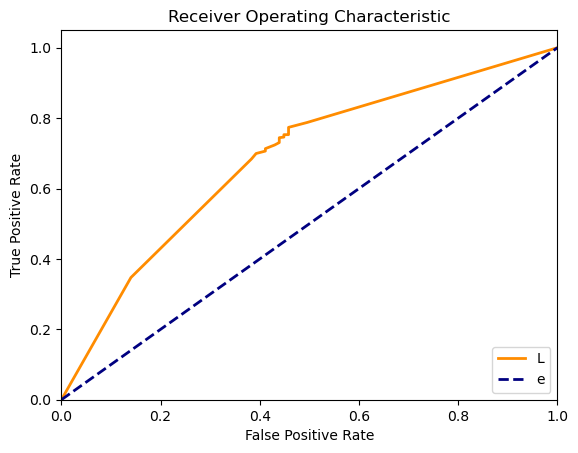

In [25]:
import matplotlib.pyplot as plt 
plt.figure() 
lw = 2 
plt.plot(false_pos_rate, true_pos_rate, 
         color='darkorange', lw=lw) 
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--') 
plt.xlim([0.0, 1.0]) 
plt.ylim([0.0, 1.05]) 
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.title('Receiver Operating Characteristic') 
plt.legend("Legend",loc="lower right") 
plt.show()

In [26]:
from sklearn.metrics import roc_auc_score
roc_auc_score(Y_test, pos_prob)

0.6857375752586637

## Tuning the model with cross-validation

### The k-fold cross-validation is used, whereby the original data is first randomly divided into k equal-sized subsets (where each class proportion is often preserved). 
### Each of the k-fold subsets is then successively retained as the testing set to be used in the model evaluation. 
### During the trials the remaining k-1 subsets(excluding the one-fold holdout) comprise the training set for the model. 
### The final step calculates the average performance across all k-trials for the overall result.

In [33]:
# splitting the model while retaining class distribution:
from sklearn.model_selection import StratifiedKFold 
k = 5 
k_fold = StratifiedKFold(n_splits=k, random_state=None)

### Following the 5 -fold generator, these parameter values are examined: 
#### 1) alpha: - represents the smoothing factor, the intial value for each feature
#### 2) fit_prior: - represents whether to use prior tailored to the training data

In [34]:
smoothing_factor_option = [1, 2, 3, 4, 5, 6]
fit_prior_option = [True, False] 
auc_record = {}

### The process of  classifier initialization, training, and prediction is then repeated for each fold generated by the split on the k-fold set and record the AUC's.

In [37]:
for train_indices, test_indices in k_fold.split(X, Y):
    X_train_k, X_test_k =X[train_indices], X[test_indices] 
    Y_train_k, Y_test_k = Y[train_indices], Y[test_indices] 
    for alpha in smoothing_factor_option:
        if alpha not in auc_record:
            auc_record[alpha] = {}
        for fit_prior in fit_prior_option:
            clf = MultinomialNB(alpha=alpha,
                                 fit_prior=fit_prior) 
            clf.fit(X_train_k, Y_train_k)

In [40]:
prediction_prob = clf.predict_proba(X_test_k) 
pos_prob = prediction_prob[:,1] 
auc = roc_auc_score(Y_test_k, pos_prob) 
auc_record[alpha][fit_prior] = auc + auc_record[alpha].get(fit_prior,0.0)

In [42]:
for smoothing, smoothing_record in auc_record.items():
    for fit_prior, auc in smoothing_record.items():
        print(f'   {smoothing}   {fit_prior}    {auc/k:.5f}') 


   6   False    0.12373


## The model is then trained with the best set of hyperparameters and the AUC is computed. 

In [43]:
clf = MultinomialNB(alpha=2.0, fit_prior=False) 
clf.fit(X_train, Y_train) 
pos_prob = clf.predict_proba(X_test)[:, 1] 
print('AUC with the best model:', roc_auc_score(Y_test, pos_prob)) 


AUC with the best model: 0.6862056720417091
